
### 신세계 주가 분석

* 현상황
    - 코로나로 인한 급격한 사회 변화로 기존의 오프라인 유통망 중심의 기업에 큰 타격이 있음
*  투자 전략
    - 웹 크롤링을 통한 빅데이터 분석을 활용 경쟁사 분석및 투자 모멘텀 확보
    - 급격한 하락장에서 손실을 만회하기위한 주식 모멘텀 투자전략을 확보
    - 불확실성이 증대된 시장에서의 생존 전략은 단타 모멘텀 전략필요
    - 발빠른 손실 보전을 통해 이익보다는 손실 방어에 주력
    - 기존에 투자전략인 5-20 투자 전략의 경우 30% 정도 하락한 시장에서 20% 대 하락에 머물렀으나
    - 3-5 투자 전략을 사용한 결과 5% 미만의 손실 낙폭을 줄일수 있었음
* 주가 개선안
    - 온라인 기반의 유통사들이 빠르게 오프라인 유통사의 경쟁자로 부각
    - 빠르고 다각화된 온라인 유통시장 전개로 시대 변화에 적응 필요
    

In [292]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3

In [293]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [294]:
dbname="naverstock.db"
def seldb(scode='004170',frday=0):
    with sqlite3.connect(dbname) as conn:
        cur=conn.cursor()
        #sqlins="insert into ..."
        sqlsel="select SDAY,SOPEN,SHIGH,SLOW,SCLOSE,SVOL from stockdata where scode='{0}' and sday>{1} order by SDAY asc".format(scode,frday)
        sdata=cur.execute(sqlsel).fetchall()
    return sdata

In [295]:
nstock=seldb('004170',frday=20200101)
len(nstock)

189

In [296]:
col=['SDAY','SOPEN','SHIGH','SLOW','SCLOSE','SVOL']
sf=pd.DataFrame(data=nstock,columns=col)
sf.head()

,SDAY,SOPEN,SHIGH,SLOW,SCLOSE,SVOL
0,20200102,289500,296500,289500,292500,48510
1,20200103,296500,297000,290500,292500,40984
2,20200106,288000,294000,288000,290000,24759
3,20200107,293000,311500,291500,305000,99705
4,20200108,305000,312000,299000,306500,73747


In [297]:
### 네이버 데이터랩 검색어 분석
import json
import urllib.request

In [298]:
client_id = "AxlZLFBq56292ad9ifql"
client_secret = "4Coe6Akx4G"

In [299]:
url = "https://openapi.naver.com/v1/datalab/search";
jbody = {
    'startDate' : '2020-01-01',
    'endDate' : '2020-10-07',
    'timeUnit' : 'date',        # input : [date, week, month]
    'keywordGroups' : [         #
        {
            'groupName': '신세계',
            'keywords': ['쓱배송', '신세계백화점','이마트']
        },{
            'groupName': '온라인',
            'keywords': ['네이버쇼핑', '쿠팡', '위메프']
        }
    ]
}
body=json.dumps(jbody,ensure_ascii=False)
request = urllib.request.Request(url)

request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))

rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
else:
    print("Error Code:" + rescode)
data = json.loads(response_body)
tmp = pd.DataFrame(data['results'])
print(tmp)


  title            keywords                                               data
0   신세계  [쓱배송, 신세계백화점, 이마트]  [{'period': '2020-01-01', 'ratio': 15.30463}, ...
1   온라인    [네이버쇼핑, 쿠팡, 위메프]  [{'period': '2020-01-01', 'ratio': 34.94599}, ...


In [300]:
res = data['results'][0]['data']
df1=pd.DataFrame(res).set_index("period")
res = data['results'][1]['data']
df2=pd.DataFrame(res).set_index("period")
df1.columns=["shin"]
df2.columns=["on-line"]
maindf=pd.merge(df1,df2,left_index=True,right_index=True)
maindf[['shin',"on-line"]]=maindf[['shin',"on-line"]]/100
print(maindf.head())

                shin   on-line
period                        
2020-01-01  0.153046  0.349460
2020-01-02  0.052618  0.466562
2020-01-03  0.047192  0.415025
2020-01-04  0.051422  0.325820
2020-01-05  0.058543  0.330313


### 데이터 전처리
* min/max 처리
* 데이터 병합
* 윈도우 생성



In [301]:
sf.head()

,SDAY,SOPEN,SHIGH,SLOW,SCLOSE,SVOL
0,20200102,289500,296500,289500,292500,48510
1,20200103,296500,297000,290500,292500,40984
2,20200106,288000,294000,288000,290000,24759
3,20200107,293000,311500,291500,305000,99705
4,20200108,305000,312000,299000,306500,73747


In [302]:
# 데이터 병합을 위해 날짜 인덱스 생성및 MINMAX 처리
days=[str(d)[0:4]+"-"+str(d)[4:6]+"-"+str(d)[6:8] for d in sf['SDAY']]
col=['SOPEN','SHIGH','SLOW','SCLOSE','SVOL']
movdf=pd.DataFrame()
sf[col]=sf[col]/350000
sf.index=days


In [303]:
# 필요데이터만 수집
movdf=sf[col]
movdf.head()

,SOPEN,SHIGH,SLOW,SCLOSE,SVOL
2020-01-02,0.827143,0.847143,0.827143,0.835714,0.138600
2020-01-03,0.847143,0.848571,0.830000,0.835714,0.117097
2020-01-06,0.822857,0.840000,0.822857,0.828571,0.070740
2020-01-07,0.837143,0.890000,0.832857,0.871429,0.284871
2020-01-08,0.871429,0.891429,0.854286,0.875714,0.210706


In [304]:
# 주가데이터와 네이버 데이터랩의 정보 병합
# 융합형 빅데이터의 인공지능 통합 정보 분석
alldf=pd.merge(movdf,maindf,how="outer",left_index=True,right_index=True)
interdf=alldf.interpolate().fillna(0)
interdf.head(10)

,SOPEN,SHIGH,SLOW,SCLOSE,SVOL,shin,on-line
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.153046,0.349460
2020-01-02,0.827143,0.847143,0.827143,0.835714,0.138600,0.052618,0.466562
2020-01-03,0.847143,0.848571,0.830000,0.835714,0.117097,0.047192,0.415025
2020-01-04,0.839048,0.845714,0.827619,0.833333,0.101645,0.051422,0.325820
2020-01-05,0.830952,0.842857,0.825238,0.830952,0.086192,0.058543,0.330313
2020-01-06,0.822857,0.840000,0.822857,0.828571,0.070740,0.046356,0.451977
2020-01-07,0.837143,0.890000,0.832857,0.871429,0.284871,0.043494,0.463623
2020-01-08,0.871429,0.891429,0.854286,0.875714,0.210706,0.043317,0.442540
2020-01-09,0.877143,0.902857,0.875714,0.898571,0.247463,0.043396,0.429066
2020-01-10,0.894286,0.911429,0.890000,0.892857,0.134794,0.042490,0.386539


<AxesSubplot:>

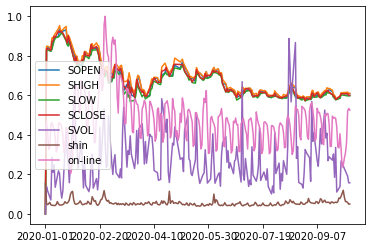

In [305]:
interdf.plot()

In [306]:
###  데이터 전처리 윈도우 스크린
srcdata=interdf.values
v=len(srcdata)
v

281

In [307]:
# 윈도우화
winsize=5
x_data=[]
y_data=[]
for i in range(v-winsize):
    x_data.append(srcdata[i:i+winsize])
    y_data.append(srcdata[i+winsize][3])
x_data=np.array(x_data).astype('float32')    
y_data=np.array(y_data).astype('float32')   

In [308]:
len(x_data)

276

### 

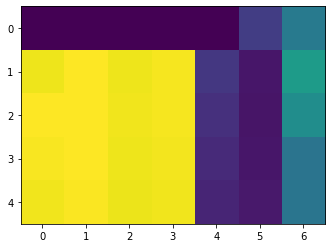

In [309]:
### 딥러닝 
x_data[0].shape
plt.imshow(x_data[0])

In [310]:
cutlimt=250
x_train=x_data[:cutlimt]
y_train=y_data[:cutlimt]
x_test=x_data[cutlimt:]
y_test=y_data[cutlimt:]

src_test=srcdata[:cutlimt]
print(len(y_test))
print(y_test[0])

26
0.60333335


In [311]:
### 딥러닝
model=Sequential()
model.add(LSTM(128,input_shape=(winsize,7,)))
model.add(Dense(64,activation="linear"))
model.add(Dense(1,activation="linear"))
model.compile(optimizer="sgd",loss="mse",metrics=['cosine_proximity'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128)               69632     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 77,953
Trainable params: 77,953
Non-trainable params: 0
_________________________________________________________________


In [312]:
model.fit(x_train,y_train,epochs=30)

Train on 250 samples
Epoch 1/30
250/250 [==============================] - 2s 7ms/sample - loss: 0.2608 - cosine_proximity: 0.6400
Epoch 2/30
250/250 [==============================] - 0s 108us/sample - loss: 0.0130 - cosine_proximity: 1.0000
Epoch 3/30
250/250 [==============================] - 0s 92us/sample - loss: 0.0036 - cosine_proximity: 1.0000
Epoch 4/30
250/250 [==============================] - 0s 100us/sample - loss: 0.0033 - cosine_proximity: 1.0000
Epoch 5/30
250/250 [==============================] - 0s 104us/sample - loss: 0.0032 - cosine_proximity: 1.0000
Epoch 6/30
250/250 [==============================] - 0s 96us/sample - loss: 0.0032 - cosine_proximity: 1.0000
Epoch 7/30
250/250 [==============================] - 0s 104us/sample - loss: 0.0032 - cosine_proximity: 1.0000
Epoch 8/30
250/250 [==============================] - 0s 92us/sample - loss: 0.0031 - cosine_proximity: 1.0000
Epoch 9/30
250/250 [==============================] - 0s 100us/sample - loss: 0.0031 - c

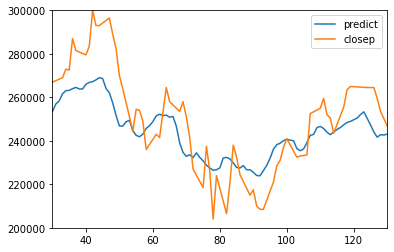

In [313]:

predict_c=model.predict(x_train)*350000
closep=[x[3]*350000 for x in srcdata[:cutlimt]]
closep
plt.plot(predict_c,label="predict")
plt.plot(closep,label="closep")
plt.xlim(30,130)
plt.ylim(200000,300000)
plt.legend()
plt.show()

In [337]:
sdf=[x*350000 for x in interdf["SCLOSE"]]
shindf=pd.DataFrame(data=sdf[:250])
shindf.columns=["closep"]
shindf['predict']=predict_c
shindf['diff']=(shindf['predict']-shindf['closep'])/np.abs(shindf['predict']-shindf['closep'])
shindf.head(60)

,closep,predict,diff
0,0.000000,249953.109026,1.0
1,292500.000000,268824.201822,-1.0
2,292500.000000,267635.089159,-1.0
3,291666.666667,268927.133083,-1.0
4,290833.333333,270371.800661,-1.0
5,290000.000000,273752.051592,-1.0
6,305000.000000,275691.348314,-1.0
7,306500.000000,276468.569040,-1.0
8,314500.000000,277383.017540,-1.0
9,312500.000000,278989.362717,-1.0


In [339]:
longday=0
havestock=[0 for i in range(longday)]
timing=[0 for i in range(longday)]
#havestock
size=len(shindf['diff'])
prepos=shindf['diff'][longday]#+라면 보유필요 -라면 대기

# 시작시 단기물이 장기물보다 위에 있으면 구매
if prepos > 0:
    havestock.append(1)
    timing.append(1)

else:
    havestock.append(0)
    timing.append(0)
print(len(havestock))
prehave=havestock[longday]
# 시작 다음날부터는 전일과 비교후 모멘텀 투자
for i in range(longday+1,size):
    nowpos=shindf['diff'][i]
    
    if(prepos==nowpos):
        havestock.append(prehave)
        timing.append(0)
    elif(prepos>nowpos):# 매도
        # 앞에 보유 했니?
        if(prehave):
            havestock.append(0)
            timing.append(-1)
        else:
            havestock.append(0)
            timing.append(0)
    else:# 매수 보유했으면 추가 매수 없음
        if(prehave):
            havestock.append(0)
            timing.append(0)
        else:# 보유없으므로 추가 매수
            havestock.append(1)
            timing.append(1)
    prepos=nowpos
    prehave=havestock[i]
print(len(timing))
shindf['havestock']=havestock
shindf['timing']=timing
shindf.head()

1
250


,closep,predict,diff,havestock,timing
0,0.000000,249953.109026,1.0,1,1
1,292500.000000,268824.201822,-1.0,0,-1
2,292500.000000,267635.089159,-1.0,0,0
3,291666.666667,268927.133083,-1.0,0,0
4,290833.333333,270371.800661,-1.0,0,0


In [343]:
shindf['price']=shindf['timing']*shindf['closep']*-1
shindf['profit']=shindf['price'].cumsum()

In [344]:
shindf.tail(30)

,closep,predict,diff,havestock,timing,price,profit
220,207666.666667,217589.884996,1.0,1,0,-0.0,175833.333333
221,208333.333333,217115.908861,1.0,1,0,-0.0,175833.333333
222,209000.000000,220257.461071,1.0,1,0,-0.0,175833.333333
223,212000.000000,221016.490459,1.0,1,0,-0.0,175833.333333
224,220500.000000,220228.880644,-1.0,0,-1,220500.0,396333.333333
225,222500.000000,218674.898148,-1.0,0,0,-0.0,396333.333333
226,230000.000000,216757.297516,-1.0,0,0,-0.0,396333.333333
227,225000.000000,222508.889437,-1.0,0,0,-0.0,396333.333333
228,220000.000000,224114.859104,1.0,1,1,-220000.0,176333.333333
229,215000.000000,226807.761192,1.0,1,0,-0.0,176333.333333


###  결론
* 모멘텀 투자 시뮬레이션 결과 코로나 같은 팬데믹이 있을경우 단타 예측이 더욱 손실을 줄일수 있음을 확인 하였으나 이익은 나지 못했다.
* 신세계 그룹의 뉴스 SNS NLP 분석결과 데이터 량이 많이 않고 홍보용 자료가 많아서 주가의 변동에 큰 영향을 주지 못한 것으로 파악되어 뉴스 NLP는 제외
* 대부분의 유통망을 이용하는 일반인의 경우 SNS 활동이 활발하지 않아서 이들의 관심이 높을 것으로 추측되는 네이버 데이터랩의 검색통계를 활용
* 데이터 검색량에서 주가의 유의한 영향을 주는 요소를 발견
* 이를 딥러닝 RNN을 활용 융합형 주가추정 시뮬레이션 결과 모멘텀 투자에서는 볼 수 없었던 유의한 투자 이익을 확보 할 수 있었다. 
* 10개월 에 상당한 투자 수익을 얻을 수 있었다.
* 회사 내부 자료를 활용하면 더욱 높은 결과를 가져올 것으로 추정되며
* 융합형 자료의 활용을 통해 기존 투자방식에서는 볼수 없었던 고가치한 정보를 확보 할 수 있었다.

0.6028478632478632